In [102]:
import numpy as np
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

import math
import random
from scipy import stats

import geopandas as gpd
import pandas as pd

import itertools
from collections import Counter

from ast import literal_eval

from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.cm as cm

from scipy.stats import zscore

import folium
from folium import IFrame
import branca.colormap as cmp
import json

from gensim import corpora, models

from gensim.models.coherencemodel import CoherenceModel
from wordcloud import WordCloud

## Prepare twitter data

In [4]:
def try_literal_eval(s):
    """ load python object as they are intended to be """
    try:
        return literal_eval(s)
    except ValueError:
        return s

In [5]:
%%time

_df = pd.read_csv("./preprocessed_data/nlp_geo_tweets_stopwords_cleaned.csv")
for col in ["hashtags", "tokens", "tokens_cleand", "w_pos_lemma"]:
    _df[col] = _df[col].apply(literal_eval)

_df.shape

Wall time: 41.8 s


In [6]:
LOCATIONS_ID = list(set(_df.dep_code.values))

geo_departements = "./geodata/departements.geojson"
gdf_departements = gpd.read_file(geo_departements)

_id2name = pd.Series(gdf_departements.nom.values,index=gdf_departements.code).to_dict()

In [7]:
# select only regions with more tweets than average ---> can be changed
dep_count = _df.groupby("dep_code").count()[["created_at"]]
dep_count.rename(columns={"created_at":"tweet_count"}, inplace=True)
dep_count.sort_values(by="tweet_count", ascending=False)
dep_count_filtered = dep_count[dep_count.tweet_count > dep_count.tweet_count.mean()] # can be changed
selected_dep = dep_count_filtered.index.values 
df = _df[[dep in selected_dep for dep in _df.dep_code]].copy()
df["hashtags"] = [[ht.lower() for ht in hashtags] for hashtags in df.hashtags]
df.shape

(233596, 26)

In [8]:
dep_count_geo = pd.merge(dep_count_filtered
                         , gdf_departements
                         , how='inner'
                         , right_on="code"
                         , left_on="dep_code"
                         , validate = "many_to_one"
                        ).reset_index(drop=True)
dep_count_geo["code"].astype(str)
dep_count_geo.shape


(23, 4)

## Prepare corpus

In [9]:
# build docs in format doc: [dep_code, list of tweet content material]
df_material = df[[len(mat)>0 for mat in df["hashtags"]]].copy()
docs = [list(loc_tweet) for loc_tweet in zip(df.dep_code.values, df_material["hashtags"].values)]

high_thres = 0.9
low_tresh = 30

dictionary = corpora.Dictionary(df_material['hashtags'])
dictionary.filter_extremes(no_below=low_tresh, no_above=high_thres)
corpus = [dictionary.doc2bow(tweet) for tweet in df_material['hashtags']]
wordDict = list(dictionary.token2id.keys())
tfidf = models.TfidfModel(corpus)
corpus_tfidf = [document for document in tfidf[corpus]]
df_material["tfidf"] = corpus_tfidf
texts = df_material['hashtags']

## LDA

In [30]:
list_ntopics = np.arange(3, 50, 2, dtype=int)

C_umasss = np.zeros(len(list_ntopics))

multi_n_topics=list(itertools.chain(*[[n]*n for n in list_ntopics]))
topic_id=list(itertools.chain(*[list(np.arange(n)) for n in list_ntopics]))
topics_df = pd.DataFrame(index=[multi_n_topics, topic_id])
topics_df["top_words"] = ['']*len(topics_df)

for i, n_topics in tqdm(enumerate(list_ntopics)):
    curr_model = models.LdaModel(corpus_tfidf
                                 , num_topics=n_topics
                                 , id2word=dictionary
                                 , passes=20
                                 , alpha=0.05 #[0.01]*n_topics
                                 , eta='auto'#[0.01]*len(dictionary.keys())
                                 , random_state=42
                                )

    C_umasss[i] = CoherenceModel(model=curr_model
                                 , corpus=corpus
                                 , coherence='u_mass'
                                ).get_coherence()

24it [13:45, 34.39s/it]


In [32]:
def plot_cv_cumass(ntopics,cumasss):
    # create figure and axis objects with subplots()
    fig,ax = plt.subplots(figsize=(10,7))
    # make a plot
    ax.plot(ntopics, cumasss, color="red", marker="o")
    # set x-axis label
    ax.set_xlabel("Number of topics",fontsize=14)
    # set y-axis label
    ax.set_ylabel(r"$C_{umass}$",color="red",fontsize=14)
    ax.grid(axis = 'x')
    plt.xticks(ntopics)
    plt.show()
    fig.savefig("lda_coherence_plot", dpi=300)

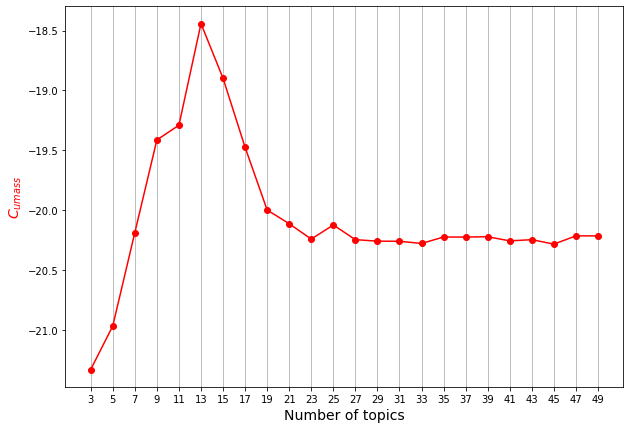

In [33]:
plot_cv_cumass(list_ntopics, C_umasss)

In [34]:
curr_model_13 = models.LdaModel(corpus_tfidf
                                 , num_topics=13
                                 , id2word=dictionary
                                 , passes=20
                                 , alpha=0.05 #[0.01]*n_topics
                                 , eta='auto'#[0.01]*len(dictionary.keys())
                                 , random_state=42
                                )

In [37]:
topic_label = [f"lda_{i+1}" for i in range(13)]

for i in range(13):
    topic = curr_model_13.get_topic_terms(i, topn=10)
    topic_ = [f'{word[1]:.3f}*{dictionary.id2token[word[0]]}' for word in topic]
    t = [(word[1], dictionary.id2token[word[0]])for word in topic]
    topics.append(t)
    print(f'{i+1:02d}: {topic_label[i]}')
    print(topic_)
    print()

01: lda_1
['0.239*france', '0.157*sarahhalimi', '0.085*icitoutcommence', '0.085*fcnol', '0.080*jeuxvideo', '0.079*nantes', '0.063*retrogaming', '0.062*dunkerque', '0.059*tchad', '0.038*covid_19']

02: lda_2
['0.582*kohlanta', '0.163*covid19', '0.106*kohlanta2021', '0.084*thevoice', '0.030*concours', '0.026*notredamedeparis', '0.000*castex18h', '0.000*vaccination', '0.000*covid19france', '0.000*paris']

03: lda_3
['0.144*lvda4', '0.139*lmad', '0.137*marseille', '0.094*hautsdefrance', '0.076*afp', '0.075*spring', '0.074*dna', '0.068*accident', '0.067*electricfull', '0.056*wweraw']

04: lda_4
['0.244*hdpros', '0.150*macron', '0.103*regionales2021', '0.086*patrimoine', '0.082*streetart', '0.076*imolagp', '0.046*football', '0.044*ede', '0.044*rn', '0.040*parismaville']

05: lda_5
['0.095*ucl', '0.085*missionalpha', '0.084*gay', '0.080*culture', '0.080*sport', '0.074*psgbay', '0.063*printemps', '0.062*strasbourg', '0.059*thomaspesquet', '0.057*confinement']

06: lda_6
['0.372*chat', '0.347*p

In [39]:
topics = []
for i in range(len(topic_label)):
    topic = curr_model_13.get_topic_terms(i, topn=10)
    topic = [dictionary.id2token[word[0]] for word in topic]
    topics.append(", ".join(topic))


df_lda_short = pd.DataFrame()
df_lda_short["topic"] = topic_label
df_lda_short["hashtags"] = topics
df_lda_short.to_csv("df_lda_short.csv", index=False)
df_lda_short

topic                                           hashtags
0    lda_1  france, sarahhalimi, icitoutcommence, fcnol, j...
1    lda_2  kohlanta, covid19, kohlanta2021, thevoice, con...
2    lda_3  lvda4, lmad, marseille, hautsdefrance, afp, sp...
3    lda_4  hdpros, macron, regionales2021, patrimoine, st...
4    lda_5  ucl, missionalpha, gay, culture, sport, psgbay...
5    lda_6  chat, perdu, trouvé, chien, nature, warzone, r...
6    lda_7  olasm, ol, cotedazurfrance, montpellier, nice0...
7    lda_8  teamom, sdrom, ramadanmubarak, vaccination, wr...
8    lda_9  saccageparis, paris, rambouillet, art, avenued...
9   lda_10  topchef, pekinexpress, eelv, ramadan, biarritz...
10  lda_11  noplp, handicap, aah17juin, baptiste, punchlin...
11  lda_12  superleague, tpmp, reta, psgsco, psg, perez, t...
12  lda_13  stopdictature, macrondestitution, superleagueo...

In [76]:
df_material["topic"] = [curr_model_13.get_document_topics(item) for item in df_material.tfidf]

In [77]:
df_material_clean = df_material[[len(corpus) > 0 for corpus in df_material.tfidf]].copy()
df_material_clean.shape

(11700, 28)

In [78]:
df_dep_hashtags = df_material_clean.groupby(["dep_code"]).count()[["created_at"]]
df_dep_hashtags.rename(columns={'created_at':'tweet_count'}, inplace=True)

In [79]:
df_dep_hashtags["all_topic"] = [np.sum(df_material_clean[df_material_clean.dep_code==dep_code].topic)
                                  for dep_code in df_dep_hashtags.index]

In [80]:
df_dep_hashtags

tweet_count                                          all_topic
dep_code                                                                
06                552  [(0, 0.6363634), (1, 0.030303048), (2, 0.03030...
13                787  [(0, 0.030303061), (1, 0.030303061), (2, 0.636...
31                358  [(0, 0.030303093), (1, 0.030303093), (2, 0.636...
33                311  [(0, 0.030303061), (1, 0.030303061), (2, 0.636...
34                486  [(0, 0.030303083), (1, 0.030303083), (2, 0.030...
35                140  [(0, 0.030303039), (1, 0.63636357), (2, 0.0303...
44                355  [(0, 0.030303068), (1, 0.030303068), (2, 0.030...
57                205  [(0, 0.030303176), (1, 0.6363619), (2, 0.03030...
59                532  [(0, 0.03030311), (1, 0.03030311), (2, 0.03030...
62                221  [(0, 0.3683787), (1, 0.02422273), (2, 0.024222...
64                344  [(0, 0.030303046), (1, 0.030303046), (2, 0.030...
67                153  [(0, 0.030303106), (1, 0.030303106), (2, 0.030...
69                679  [(0, 0.030303076), (1, 0.030303076), (2, 0.030...
75               2984  [(0, 0.030303081), (1, 0.030303081), (2, 0.030...
76                473  [(0, 0.030303046), (1, 0.030303046), (2, 0.030...
77                261  [(0, 0.030303067), (1, 0.030303067), (2, 0.030...
78                313  [(0, 0.030303081), (1, 0.030303081), (2, 0.030...
83                365  [(0, 0.030303117), (1, 0.030303117), (2, 0.030...
91                301  [(0, 0.030303292), (1, 0.030303292), (2, 0.030...
92                591  [(0, 0.030303061), (1, 0.030303061), (2, 0.636...
93                616  [(0, 0.030303117), (1, 0.030303117), (2, 0.030...
94                341  [(0, 0.030303068), (1, 0.030303068), (2, 0.030...
95                332  [(0, 0.030303061), (1, 0.030303061), (2, 0.636...

In [81]:
def aggregate(topic, count):
    topic_dict = dict()
    for item in topic:
        topic_dict[item[0]] = topic_dict.get(item[0], 0) + item[1]
    for key in topic_dict.keys():
        topic_dict[key] = topic_dict[key]/count
    return sorted(list(topic_dict.items()),key = lambda x: x[1], reverse=True )

In [82]:
df_dep_hashtags["topic_dist"] = [aggregate(topic, tweet_count) for topic, tweet_count
                                 in zip(df_dep_hashtags.all_topic, df_dep_hashtags.tweet_count)]

In [85]:
df_dep_hashtags = pd.merge(df_dep_hashtags
                         , gdf_departements
                         , how='inner'
                         , right_on="code"
                         , left_on="dep_code"
                         , validate = "many_to_one"
                        ).reset_index(drop=True)
df_dep_hashtags["code"].astype(str)
df_dep_hashtags.shape

(23, 6)

In [86]:
topics_ = []
for i in range(13):
    topic = curr_model_13.get_topic_terms(i, topn=10)
    topic_ = [f'{word[1]:.3f}*{dictionary.id2token[word[0]]}' for word in topic]
    t = [(word[1], dictionary.id2token[word[0]])for word in topic]
    topics_.append(t)

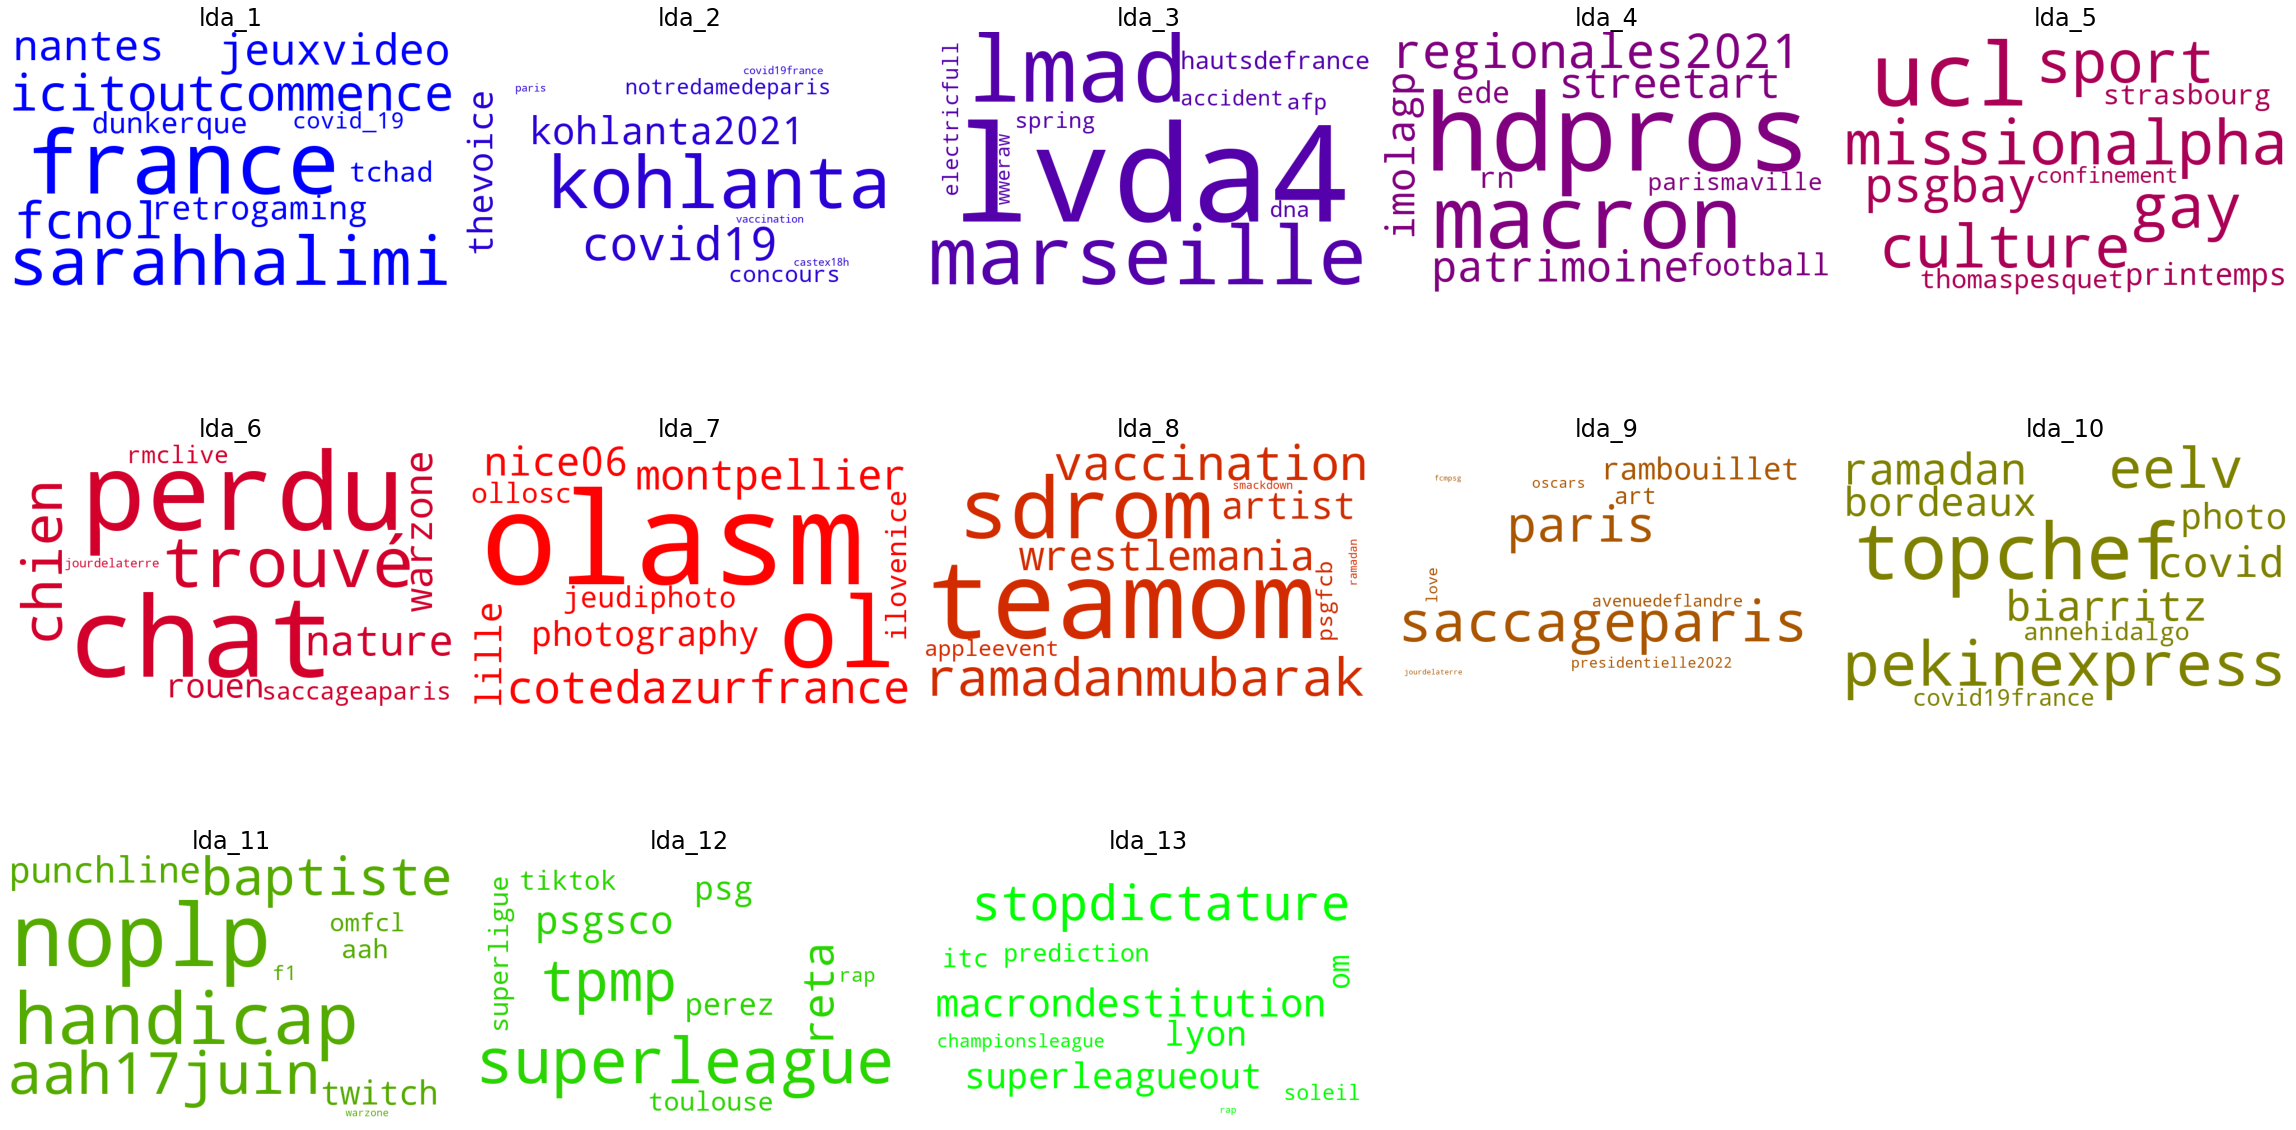

In [64]:
fig = plt.figure(figsize=(32,18))
cmap = cm.get_cmap('brg')
k = np.linspace(0, 1, 13)
for i, topic in enumerate(topics_):
    c = cmap(k[i])
    c = c[:3]
    c = tuple([int(k*255) for k in c])
    data = dict()
    for p, word in topic:
        data[word] = p
    wc = WordCloud(width=800
                   , height=480
                   , max_words=10
                   , color_func=lambda *args, **kwargs: c
                   , background_color='white').generate_from_frequencies(data)
    ax = fig.add_subplot(3, 5, i+1)
    ax.set_title(f"{topic_label[i]}", fontsize=24)
    ax.imshow(wc)
    plt.axis('off')
plt.tight_layout()
plt.show
fig.savefig('topic_wordcloud_lda.eps', bbox_inches='tight')
fig.savefig('topic_wordcloud_lda.png', bbox_inches='tight', dpi=300)

In [92]:
df_dep_hashtags["topic_dist"] = [sorted(t, key= lambda x:x[0]) for t in df_dep_hashtags.topic_dist]

In [94]:
dks = list(df_dep_hashtags.topic_dist)

for i in range(13):
    df_dep_hashtags[topic_label[i]] = [t[i][1] for t in dks]

In [100]:
df_dep_lda = df_dep_hashtags.drop(['tweet_count', 'all_topic', 'topic_dist', 'code', 'geometry'], axis=1)
df_dep_lda = df_dep_lda.set_index("nom")
df_dep_lda.head(3)

lda_1     lda_2     lda_3     lda_4     lda_5     lda_6  \
nom                                                                            
Alpes-Maritimes   0.048521  0.130424  0.048911  0.073908  0.050059  0.070047   
Bouches-du-Rhône  0.049221  0.080636  0.087499  0.049273  0.051763  0.096065   
Haute-Garonne     0.067241  0.110441  0.055031  0.055606  0.073972  0.194804   

                     lda_7     lda_8     lda_9    lda_10    lda_11    lda_12  \
nom                                                                            
Alpes-Maritimes   0.243451  0.049106  0.063461  0.060020  0.039654  0.082697   
Bouches-du-Rhône  0.042822  0.179815  0.043011  0.053981  0.123742  0.076318   
Haute-Garonne     0.043733  0.050981  0.046647  0.078289  0.028973  0.162549   

                    lda_13  
nom                         
Alpes-Maritimes   0.039741  
Bouches-du-Rhône  0.065855  
Haute-Garonne     0.031734

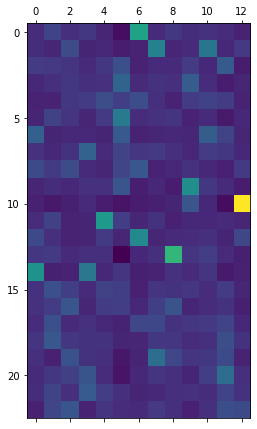

In [103]:
obs = df_dep_lda.to_numpy()
chi2, p, dof, ex = stats.chi2_contingency(obs)
cont_mat = pd.DataFrame(columns=df_dep_lda.columns, index=df_dep_lda.index, dtype=float)

for i, row in enumerate(obs):
    for j, n in enumerate(row):
        cont_mat.iloc[i, j] = (n - ex[i, j])/np.sqrt(ex[i, j]) # according to https://docs.cortext.net/contingency-matrix/
plt.matshow(cont_mat)

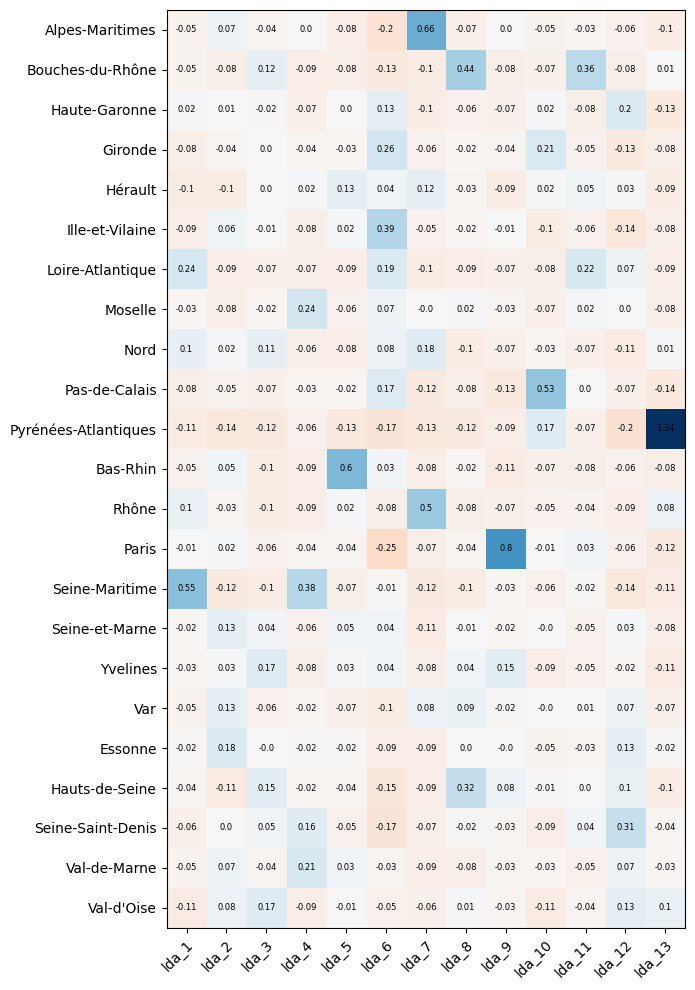

In [104]:
fig, ax = plt.subplots(1,1,figsize=(10,10), dpi=100)

departments = cont_mat.index.to_list()
hashtags = cont_mat.columns.to_list()

max_abs_value = np.max([np.abs(cont_mat.max().max()), np.abs(cont_mat.min().min())])

im = ax.imshow(cont_mat
               , cmap='RdBu'
               #, alpha=0.8
               , vmin=-max_abs_value
               , vmax=max_abs_value
              )

# We want to show all ticks...
ax.set_xticks(np.arange(len(hashtags)))
ax.set_yticks(np.arange(len(departments)))
# ... and label them with the respective list entries
ax.set_xticklabels(hashtags)
ax.set_yticklabels(departments)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(departments)):
    for j in range(len(hashtags)):
        text = ax.text(j, i, cont_mat.iloc[i, j].round(decimals=2),
                       ha="center", va="center", color="black", size=6)

fig.tight_layout()
plt.show()
fig.savefig('contingency_matrix_lda.eps', bbox_inches='tight')

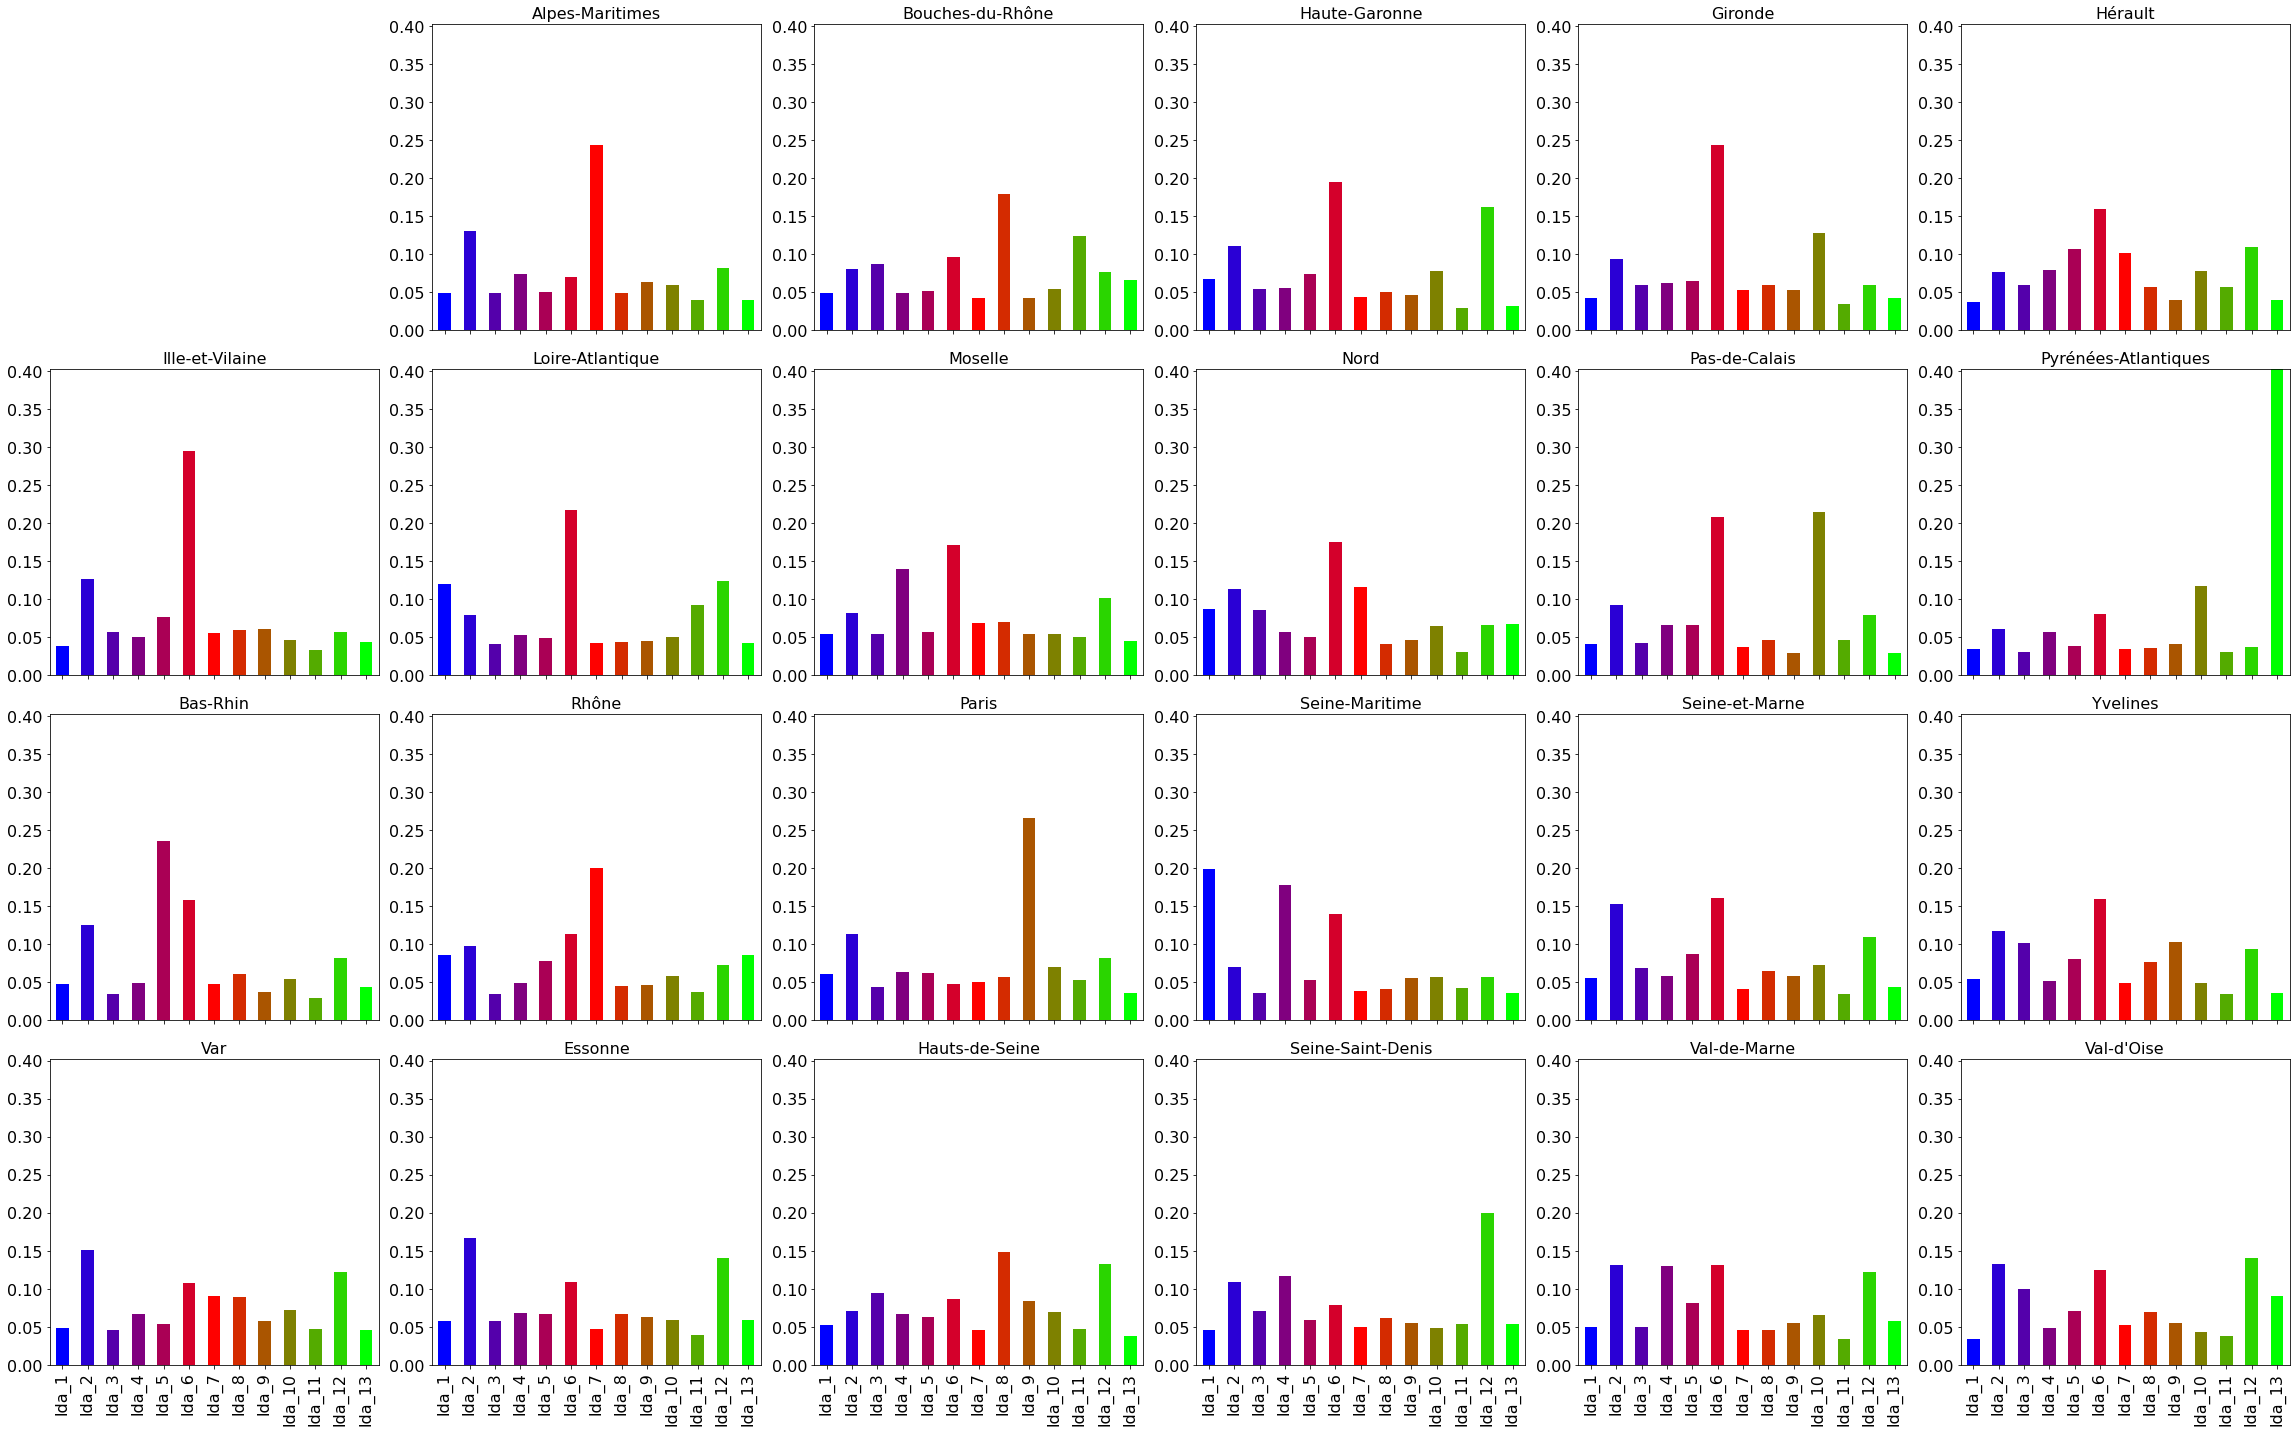

In [106]:
df_dep_lda_norm = df_dep_lda.div(df_dep_lda.sum(axis=1), axis=0)
max_y = df_dep_lda_norm.max().max()
fig = plt.figure(figsize=(32,20))

i = 0
prev_ax = None

cmap = cm.get_cmap('brg')
color = [cmap(i) for i in np.linspace(0,1, df_dep_lda_norm.shape[1])]
for dep, lda_coms in df_dep_lda_norm.iterrows():
    
    ax = fig.add_subplot(4, 6, i+2, sharex=prev_ax)
    
    ax = lda_coms.plot.bar(fontsize=16, color=color)
    prev_ax = ax
    ax.set_title(f"{dep}", fontsize=16)
    ax.set_ylim((0, max_y))
    # ax.imshow(wc)
    #plt.axis('off')
    i+=1
    
plt.tight_layout()
plt.show()
fig.savefig('lda_communities_histogram.eps')
fig.savefig('lda_communities_histogram.png', dpi=300)

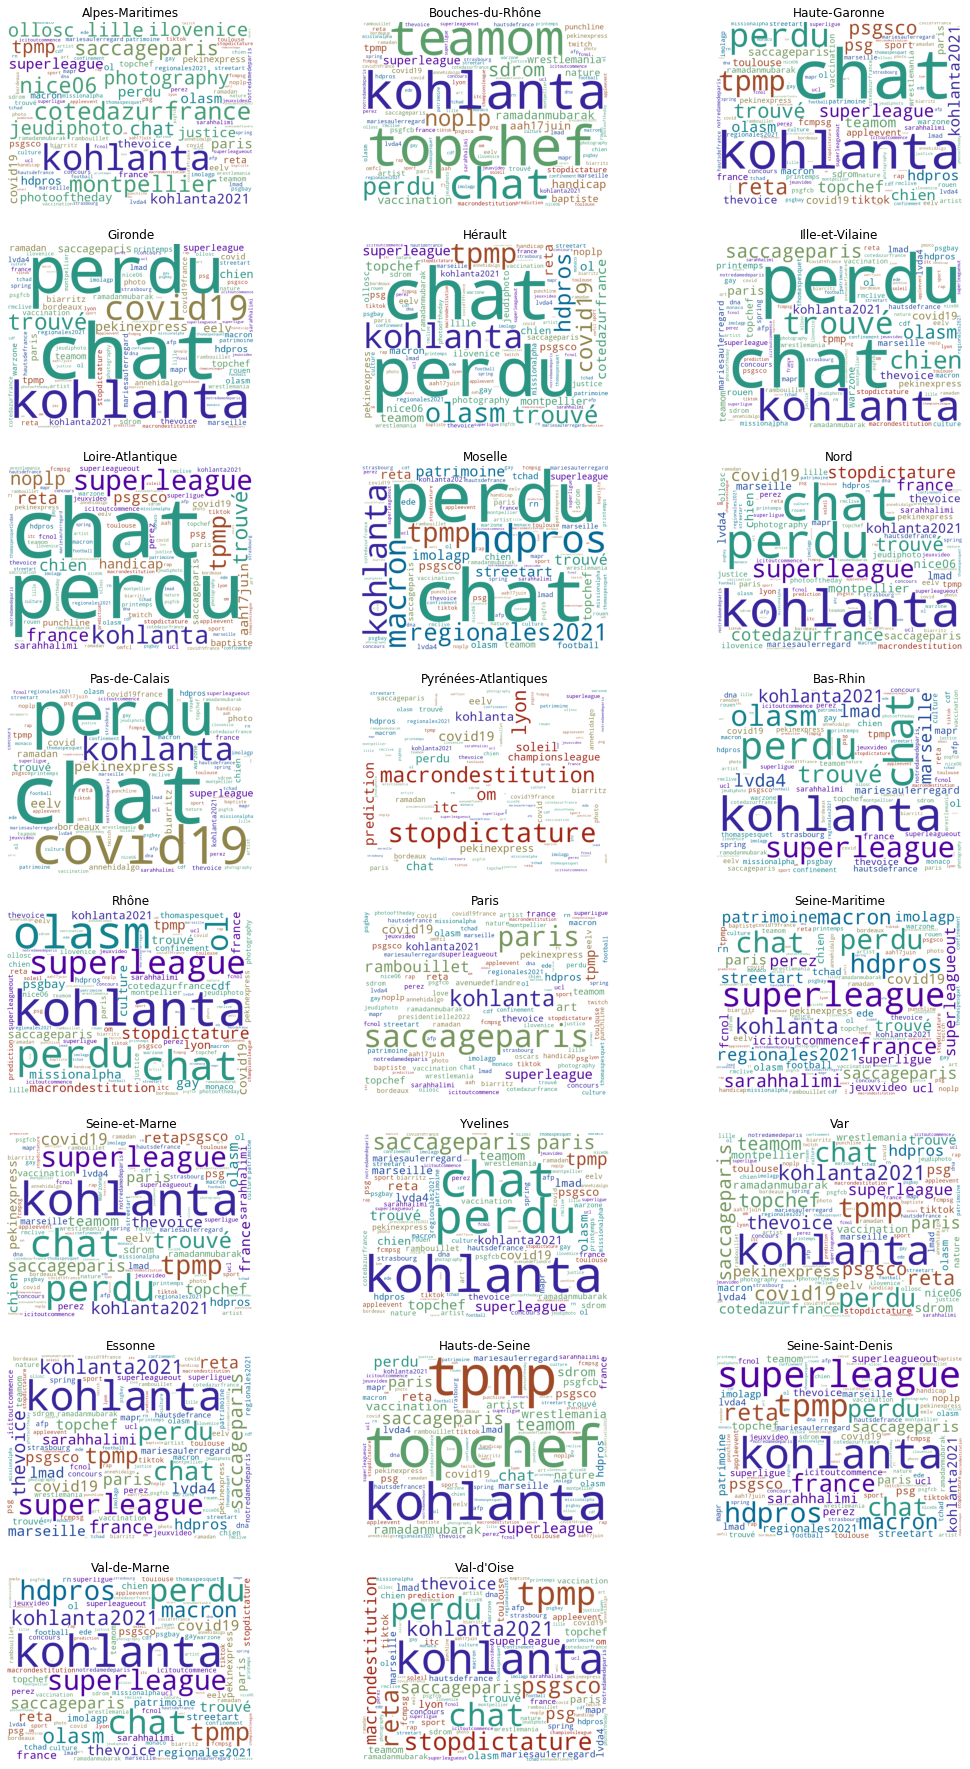

In [274]:
fig = plt.figure(figsize=(18,32))
cmap = cm.get_cmap('rainbow')


for _, r in df_dep_hashtags.iterrows():
    loc = r["nom"]
    data = {}
    topic_data = {}
    for (t, p) in r["topic_dist"]:
        topic = topics[t]
        for pw, word in topic:
            if not word in data or data[word] <= pw*p:
                data[word] = pw*p
                topic_data[word]=t
                
    def color(word, **kwargs):
        t = topic_data[word]
        c = cmap(1.0/(len(top_topics))*t)[:3]
        c = tuple([int(k*160) for k in c])
        return c
        
    wc = WordCloud(width=800
                   , height=600
                   , max_words=200
                   , color_func=color
                   , background_color='white').generate_from_frequencies(data)
    ax = fig.add_subplot(8, 3, _+1)
    ax.set_title(f"{loc}")
    ax.imshow(wc)
    plt.axis('off')
plt.show()    

In [284]:
from shapely.geometry import Point
import random
import itertools


linear = cmp.LinearColormap(
    ['white', 'blue'],
    vmin=0, vmax=3000,
    caption='tweet_count' #Caption for Color scale or Legend
).to_step(12)

code = df_dep_hashtags["code"].to_list()


cmap = cm.get_cmap('rainbow')


def style_function(feature):
    if feature["code"] in code:
        index = df_dep_hashtags[df_dep_hashtags["code"]==feature["code"]].index.values[0]
        tweet_num = df_dep_hashtags.at[index, "tweet_count"]
    else:
        tweet_num = None
    return {
        "fillOpacity": 0.5,
        "color": "black",
        "opacity": 0.25,
        "weight": 0.1,
        "fillColor": "#fff" if tweet_num is None else linear(tweet_num),
    }

m = folium.Map(
    location=[46.71109, 1.7191036],
    tiles="cartodbpositron",
    zoom_start=6,
)

for _, r in df_dep_hashtags.iterrows():
    #without simplifying the representation of each borough, the map might not be displayed
    #sim_geo = gpd.GeoSeries(r['geometry'])
    sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    geo_ = json.loads(sim_geo.to_json())
    geo_["features"][0]["code"] = r["code"]
    geo_j = folium.GeoJson(data=geo_,
                           style_function=style_function,)
    # pt = sim_geo.centroid

    loc = r["nom"]
    data = {}
    topic_data = {}
    for (t, p) in r["topic_dist"]:
        topic = topics[t]
        for pw, word in topic:
            if not word in data or data[word] <= pw*p:
                data[word] = pw*p
                topic_data[word]=t
                
    def color(word, **kwargs):
        t = topic_data[word]
        c = cmap(1.0/(len(top_topics))*t)[:3]
        c = tuple([int(k*160) for k in c])
        hexa = '#%02x%02x%02x' % c
        return hexa
        
    wc = WordCloud(width=160
                   , height=120
                   , max_words=200
                   , color_func=color
                   , background_color='white'
                   , scale= 1.0).generate_from_frequencies(data)
    svg = wc.to_svg()
    iframe = IFrame(svg, width=160+20, height=120+20)
    popup = folium.Popup(iframe, max_width=2650, sticky=True)
    popup.add_to(geo_j)
    geo_j.add_to(m)
linear.add_to(m)
        
m.save("gensim_lda_hashtags.html")   
m